### QUESTION - 1

Given a dataset along with the annotation files, Plot the below mentioned details of the dataset:
1. Class count
2. Bounding boxes per image
3. Bounding boxes per each class
4. Distribution of the bounding box size (eg: min size, max size, avg size)

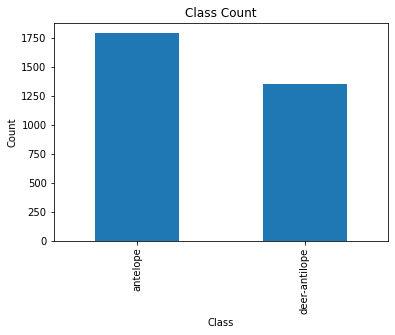

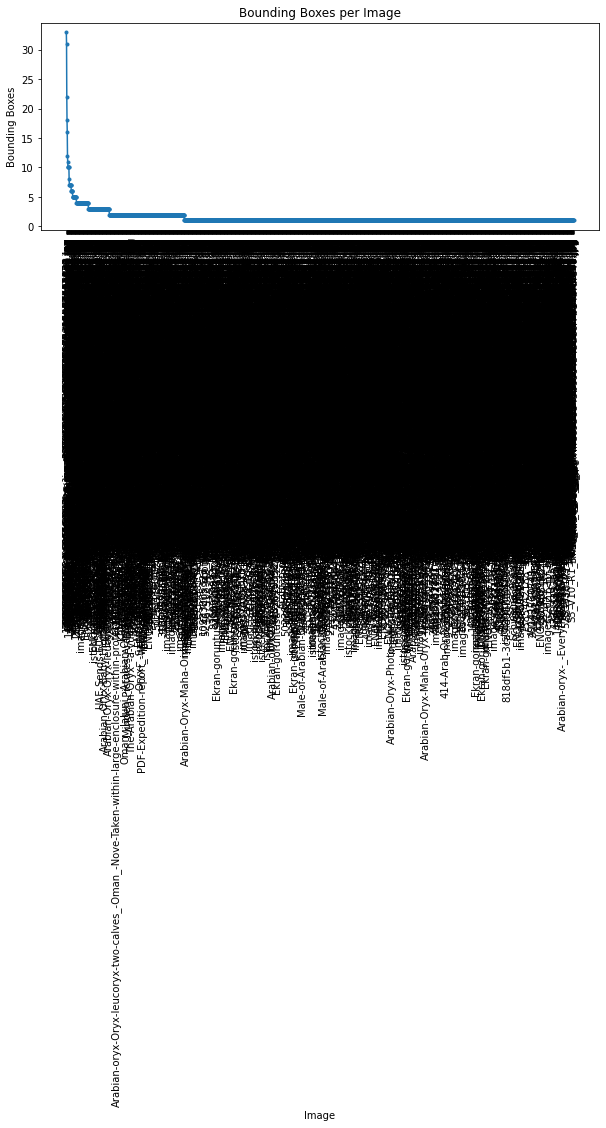

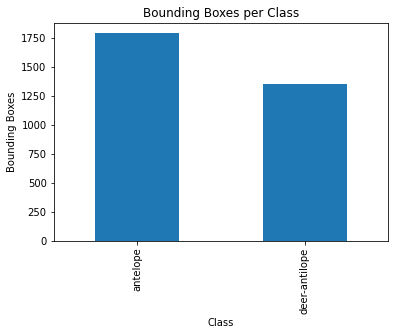

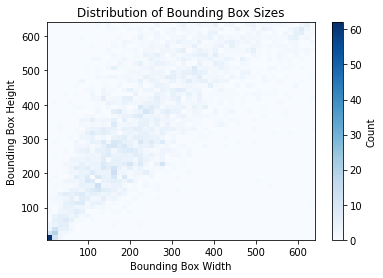

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

class AnnotationAnalizer:
    def __init__(self, dataset_dir, annotation_file):
        self.dataset_dir = dataset_dir
        self.annotation_file = annotation_file
        self.df = None

    # Function to parse annotation files in COCO format and create a DataFrame
    def read_annotation_file(self):
        with open(self. annotation_file, 'r') as f:
            data = json.load(f)

        annotations = []
        categories = data['categories']
        images = data['images']
        annotations_data = data['annotations']

        # Map category IDs to category names
        category_mapping = {category['id']: category['name'] for category in categories}

        for annotation_data in annotations_data:
            image_id = annotation_data['image_id']
            category_id = annotation_data['category_id']
            bbox = annotation_data['bbox']
            image_info = next((image for image in images if image['id'] == image_id), None)

            if image_info:
                image_name = image_info['file_name']
                annotations.append({'image': image_name, 'class_id': category_id, 'bbox': bbox})

        # Assign class labels based on class IDs
        class_labels = [category_mapping[category['id']] for category in categories]
        for annotation in annotations:
            annotation['class'] = class_labels[annotation['class_id'] - 1]

        self.df = pd.DataFrame(annotations)

    # Function to plot class count
    def plot_class_count(self):
        class_count = self.df['class'].value_counts()
        class_count.plot(kind='bar')
        plt.xlabel('Class')
        plt.ylabel('Count')
        plt.title('Class Count')
        plt.show()

    def plot_bounding_boxes_per_image(self):
        bboxes_per_image = self.df['image'].value_counts()
        image_counts = len(bboxes_per_image)
        plt.figure(figsize=(10, 6))
        plt.plot(range(image_counts), bboxes_per_image.values, marker='.')
        plt.xlabel('Image')
        plt.ylabel('Bounding Boxes')
        plt.title('Bounding Boxes per Image')
        plt.xticks(range(image_counts), bboxes_per_image.index, rotation=90)
        plt.subplots_adjust(bottom=0.4) 
        plt.show()

    # Function to plot bounding boxes per class
    def plot_bounding_boxes_per_class(self):
        bboxes_per_class = self.df['class'].value_counts()
        bboxes_per_class.plot(kind='bar')
        plt.xlabel('Class')
        plt.ylabel('Bounding Boxes')
        plt.title('Bounding Boxes per Class')
        plt.show()

    # Function to plot distribution of bounding box sizes
    def plot_bounding_box_size_distribution(self):
        self.df['bbox_width'] = self.df['bbox'].apply(lambda x: x[2])
        self.df['bbox_height'] = self.df['bbox'].apply(lambda x: x[3])

        min_size = min(self.df['bbox_width'].min(), self.df['bbox_height'].min())
        max_size = max(self.df['bbox_width'].max(), self.df['bbox_height'].max())
        avg_size = self.df[['bbox_width', 'bbox_height']].mean()

        plt.hist2d(self.df['bbox_width'], self.df['bbox_height'], bins=50, cmap='Blues')
        plt.xlabel('Bounding Box Width')
        plt.ylabel('Bounding Box Height')
        plt.title('Distribution of Bounding Box Sizes')
        plt.colorbar(label='Count')
        plt.show()
    
    
    def Analyze_Annotation(self):
        self.read_annotation_file()
        self.plot_class_count()
        self.plot_bounding_boxes_per_image()
        self.plot_bounding_boxes_per_class()
        self.plot_bounding_box_size_distribution()
    
# Main function
if __name__ ==  '__main__':
    dataset_dir = '/home/ubuntu/Desktop/animal/train/' 
    annotation_file = os.path.join(dataset_dir, '/home/ubuntu/Desktop/animal/train/_annotations.coco.json')
    
    analyzer = AnnotationAnalizer(dataset_dir, annotation_file)
    analyzer.Analyze_Annotation()

### QUESTION - 2

Convert a object detection dataset from one format to another: 

1. Coco to yolo format
2. Pascal VOC to coco format
3. Pascal VOC to yolo format

In [2]:
import json
import xml.etree.ElementTree as ET
import os

In [10]:
class CocoToYoloConverter:
    def __init__(self, coco_path, output_path):
        self.coco_path = coco_path
        self.output_path = output_path
        
    def convert(self):
        with open(self.coco_path, 'r') as f:
            coco_data = json.load(f)

        output_lines = []
        for image in coco_data['images']:
            for annotation in coco_data['annotations']:
                if annotation['image_id'] == image['id']:
                    image_width = image['width']
                    image_height = image['height']
                    x, y, width, height = annotation['bbox']

                    # Convert Coco format to YOLO format
                    x_center = (x + width / 2) / image_width
                    y_center = (y + height / 2) / image_height
                    normalized_width = width / image_width
                    normalized_height = height / image_height

                    # Append the converted data to output lines
                    line = f"{annotation['category_id']} {x_center} {y_center} {normalized_width} {normalized_height}"
                    output_lines.append(line)

        # Write the YOLO formatted data to a file
        with open(self.output_path, 'w') as f:
            for line in output_lines:
                f.write(line + '\n')
            
coco_path = '/home/ubuntu/Desktop/animal/train/_annotations.coco.json'
output_path = '/home/ubuntu/Desktop/Output/output1.txt'

converter = CocoToYoloConverter(coco_path, output_path)
converter.convert()

In [4]:
class PascalVOCToCocoConverter:
    def __init__(self,pascal_path,output_path):
        self.pascal_path = pascal_path
        self.output_path = output_path
        self.images = []
        self.annotations = []
        self.categories = []
        self.image_id = 0
        self.annotation_id = 0

    # Iterate through all XML files in the folder
    def convert(self):
        for filename in os.listdir(self.pascal_path):
            if filename.endswith('.xml'):
                xml_path = os.path.join(self.pascal_path, filename)
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Process image information
                image_info = {
                    'id': self.image_id,
                    'width': int(root.find('size/width').text),
                    'height': int(root.find('size/height').text),
                    'file_name': filename.replace('.xml', '')
                }
                self.images.append(image_info)

                # Process object annotations
                for obj in root.findall('object'):
                    bbox = obj.find('bndbox')
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)

                    annotation = {
                        'id': self.annotation_id,
                        'image_id': self.image_id,
                        'category_id': 0,  # Assuming there is only one class
                        'bbox': [xmin, ymin, xmax - xmin, ymax - ymin],
                        'area': (xmax - xmin) * (ymax - ymin),
                        'iscrowd': 0
                    }
                    self.annotations.append(annotation)
                    self.annotation_id += 1

                self.image_id += 1

        self.categories.append({'id': 0, 'name': 'object'})  # Assuming there is only one class

        coco_data = {
            'images': self.images,
             'annotations': self.annotations,
            'categories': self.categories
        }

        with open(self.output_path, 'w') as f:
            json.dump(coco_data, f)
        
pascal_path = '/home/ubuntu/Desktop/animal detection.v7-semi-fixed-labels-640x640.voc/train'
output_path = '/home/ubuntu/Desktop/Output/output2.json'

converter = PascalVOCToCocoConverter(pascal_path, output_path)
converter.convert()

In [5]:
class PascalVOCToYOLOConverter:
    def __init__(self, pascal_folder, output_folder):
        self.pascal_folder = pascal_folder
        self.output_folder = output_folder
        
        
    def convert(self):
        # Create the output folder if it doesn't exist
        os.makedirs(self.output_folder, exist_ok=True)

        # Iterate through all XML files in the folder
        for filename in os.listdir(self.pascal_folder):
            if filename.endswith('.xml'):
                xml_path = os.path.join(self.pascal_folder, filename)
                tree = ET.parse(xml_path)
                root = tree.getroot()

                image_width = int(root.find('size/width').text)
                image_height = int(root.find('size/height').text)

                # Create the output file path
                output_path = os.path.join(self.output_folder, filename.replace('.xml', '.txt'))

                with open(output_path, 'w') as f:
                    # Process object annotations
                    for obj in root.findall('object'):
                        bbox = obj.find('bndbox')
                        label = obj.find('name').text
                        xmin = float(bbox.find('xmin').text)
                        ymin = float(bbox.find('ymin').text)
                        xmax = float(bbox.find('xmax').text)
                        ymax = float(bbox.find('ymax').text)

                        # Convert Pascal VOC format to YOLO format
                        x_center = (xmin + xmax) / (2 * image_width)
                        y_center = (ymin + ymax) / (2 * image_height)
                        normalized_width = (xmax - xmin) / image_width
                        normalized_height = (ymax - ymin) / image_height

                        # Write the YOLO formatted line to the output file
                        line = f"{label} {x_center} {y_center} {normalized_width} {normalized_height}"
                        f.write(line + '\n')

pascal_path = '/home/ubuntu/Desktop/animal detection.v7-semi-fixed-labels-640x640.voc/train'
output_path = '/home/ubuntu/Desktop/Output/output3.txt'

converter = PascalVOCToYOLOConverter(pascal_path, output_path)
converter.convert()